<a href="https://colab.research.google.com/github/RifaiRifantoro/UAS_Big-Data/blob/main/uas_big_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import (LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes, LinearSVC)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 1a: Inisialisasi Spark Session
spark = SparkSession.builder.appName("Prediksi Penyakit Jantung").getOrCreate()

In [ ]:
# 1b: Memuat dataset
file_path = "/content/Heart Attack Data Set.csv"
heart_data = spark.read.csv(file_path, header=True, inferSchema=True)

In [ ]:
# 1c: Preprocessing data
# Menampilkan struktur data dan beberapa contoh data
heart_data.printSchema()
heart_data.show(5)

root
 |-- age: integer (nullable = true)
 |-- sex: integer (nullable = true)
 |-- cp: integer (nullable = true)
 |-- trestbps: integer (nullable = true)
 |-- chol: integer (nullable = true)
 |-- fbs: integer (nullable = true)
 |-- restecg: integer (nullable = true)
 |-- thalach: integer (nullable = true)
 |-- exang: integer (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- thal: integer (nullable = true)
 |-- target: integer (nullable = true)

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
| 63|  1|  3|     145| 233|  1|      0|    150|    0|    2.3|    0|  0|   1|     1|
| 37|  1|  2|     130| 250|  0|      1|    187|    0|    3.5|    0|  0|   2|     1|
| 41|  0|  1|     130| 204|  0|      0|    172|

In [ ]:
heart_data.describe().show()

+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|summary|               age|                sex|                cp|          trestbps|              chol|                fbs|          restecg|           thalach|              exang|           oldpeak|             slope|                ca|              thal|            target|
+-------+------------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               303|                303|               303|               303|               303|                303|              303|               303|    

In [ ]:
# Memeriksa nilai null
heart_data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in heart_data.columns]).show()

+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|age|sex| cp|trestbps|chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|target|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+
|  0|  0|  0|       0|   0|  0|      0|      0|    0|      0|    0|  0|   0|     0|
+---+---+---+--------+----+---+-------+-------+-----+-------+-----+---+----+------+



In [ ]:
# Menggabungkan beberapa fitur menjadi satu kolom
assembler = VectorAssembler(
    inputCols=["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"],
    outputCol="features")
data = assembler.transform(heart_data)


In [ ]:
# Menskalakan fitur
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [ ]:
# Menampilkan summary dan matriks korelasi
corr_data = data.select([c for c in data.columns if c not in ['features', 'scaledFeatures']]).toPandas()
print(corr_data.corr())

               age       sex        cp  trestbps      chol       fbs  \
age       1.000000 -0.098447 -0.068653  0.279351  0.213678  0.121308   
sex      -0.098447  1.000000 -0.049353 -0.056769 -0.197912  0.045032   
cp       -0.068653 -0.049353  1.000000  0.047608 -0.076904  0.094444   
trestbps  0.279351 -0.056769  0.047608  1.000000  0.123174  0.177531   
chol      0.213678 -0.197912 -0.076904  0.123174  1.000000  0.013294   
fbs       0.121308  0.045032  0.094444  0.177531  0.013294  1.000000   
restecg  -0.116211 -0.058196  0.044421 -0.114103 -0.151040 -0.084189   
thalach  -0.398522 -0.044020  0.295762 -0.046698 -0.009940 -0.008567   
exang     0.096801  0.141664 -0.394280  0.067616  0.067023  0.025665   
oldpeak   0.210013  0.096093 -0.149230  0.193216  0.053952  0.005747   
slope    -0.168814 -0.030711  0.119717 -0.121475 -0.004038 -0.059894   
ca        0.276326  0.118261 -0.181053  0.101389  0.070511  0.137979   
thal      0.068001  0.210041 -0.161736  0.062210  0.098803 -0.03

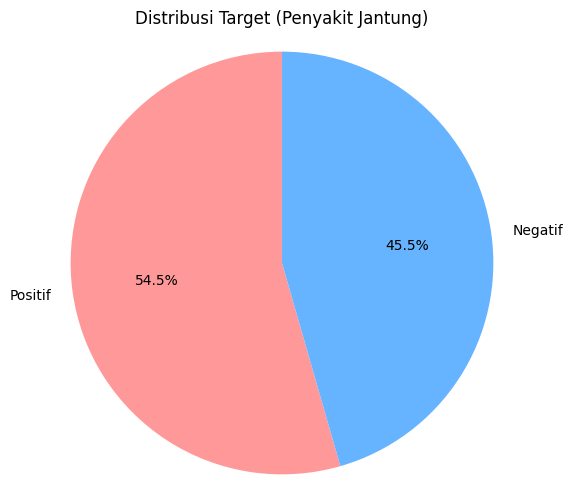

In [ ]:
# 1d: Exploratory Data Analysis (EDA)

# 1. Pie Chart - Distribusi Target (Penyakit Jantung)
plt.figure(figsize=(6, 6))
target_counts = corr_data['target'].value_counts()
labels = ['Positif', 'Negatif']
plt.pie(target_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
plt.title('Distribusi Target (Penyakit Jantung)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

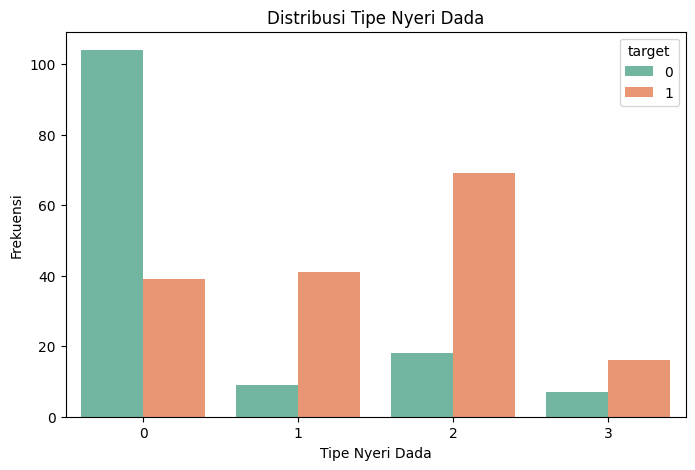

In [ ]:
# 2. Bar Chart - Distribusi Tipe Nyeri Dada
plt.figure(figsize=(8, 5))
sns.countplot(x='cp', data=corr_data, palette='Set2', hue='target')  # Menambahkan hue untuk warna berdasarkan target
plt.title('Distribusi Tipe Nyeri Dada')
plt.xlabel('Tipe Nyeri Dada')
plt.ylabel('Frekuensi')
plt.show()

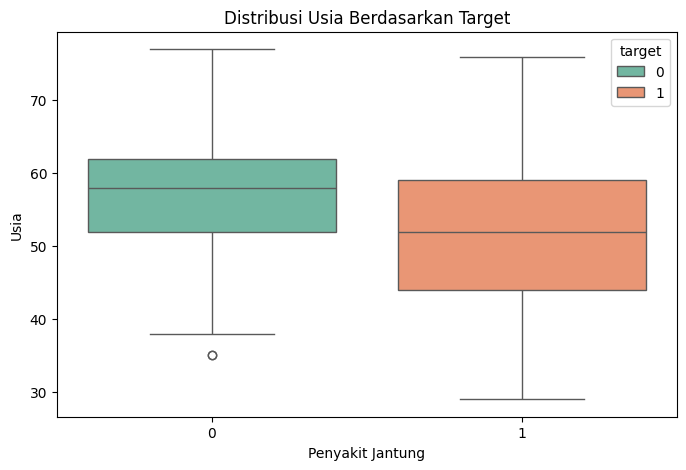

In [ ]:
# 3. Box Plot - Distribusi Usia Berdasarkan Target
plt.figure(figsize=(8, 5))
sns.boxplot(x='target', y='age', data=corr_data, palette='Set2', hue='target')
plt.title('Distribusi Usia Berdasarkan Target')
plt.xlabel('Penyakit Jantung')
plt.ylabel('Usia')
plt.show()

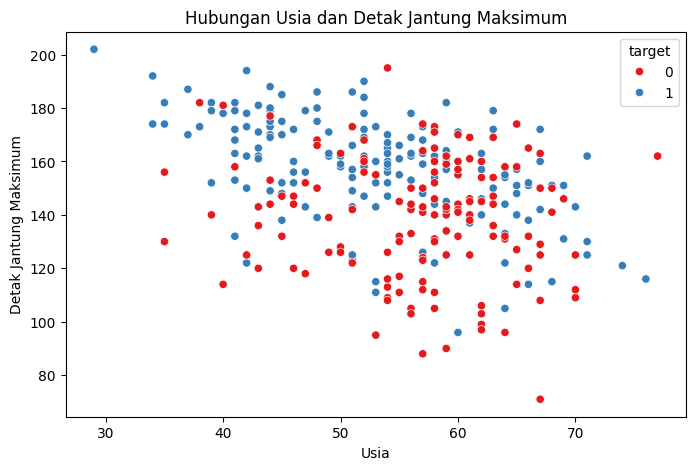

In [ ]:
# 4. Scatter Plot - Hubungan Usia dan Detak Jantung Maksimum
plt.figure(figsize=(8, 5))
sns.scatterplot(x='age', y='thalach', hue='target', data=corr_data, palette='Set1')
plt.title('Hubungan Usia dan Detak Jantung Maksimum')
plt.xlabel('Usia')
plt.ylabel('Detak Jantung Maksimum')
plt.show()

In [ ]:
# 1e: Memilih fitur berdasarkan analisis data
selected_features = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal"]
assembler = VectorAssembler(inputCols=selected_features, outputCol="features_new")
data = assembler.transform(data)

In [ ]:
# 2a: Mengembangkan model machine learning
train, test = data.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(featuresCol="scaledFeatures", labelCol="target")
gbt = GBTClassifier(featuresCol="scaledFeatures", labelCol="target")
dt = DecisionTreeClassifier(featuresCol="scaledFeatures", labelCol="target")
nb = NaiveBayes(featuresCol="scaledFeatures", labelCol="target")
svc = LinearSVC(featuresCol="scaledFeatures", labelCol="target")

In [ ]:
models = [("Random Forest", rf),
          ("Gradient Boosted Tree", gbt),
          ("Decision Tree", dt),
          ("Naive Bayes", nb),
          ("Support Vector Machine", svc)]

evaluator = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")

In [ ]:
# Evaluasi model
for name, model in models:
    fitted_model = model.fit(train)
    predictions = fitted_model.transform(test)

    # Evaluasi AUC
    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="target", metricName="areaUnderROC") # Changed labelCol to "target"
    auc = binary_evaluator.evaluate(predictions)

    # Evaluasi Akurasi
    accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="accuracy") # Changed labelCol to "target"
    accuracy = accuracy_evaluator.evaluate(predictions)

    # Evaluasi Precision
    precision_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="weightedPrecision") # Changed labelCol to "target"
    precision = precision_evaluator.evaluate(predictions)

    # Evaluasi Recall
    recall_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="weightedRecall") # Changed labelCol to "target"
    recall = recall_evaluator.evaluate(predictions)

    # Evaluasi F1-Score
    f1_evaluator = MulticlassClassificationEvaluator(labelCol="target", predictionCol="prediction", metricName="f1") # Changed labelCol to "target"
    f1_score = f1_evaluator.evaluate(predictions)

    # Menampilkan hasil evaluasi
    print(f"{name} Evaluations:")
    print(f"  AUC (Area Under Curve): {auc:.2f}")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1-Score: {f1_score:.2f}")

Random Forest Evaluations:
  AUC (Area Under Curve): 0.89
  Accuracy: 0.83
  Precision: 0.83
  Recall: 0.83
  F1-Score: 0.83
Gradient Boosted Tree Evaluations:
  AUC (Area Under Curve): 0.86
  Accuracy: 0.81
  Precision: 0.81
  Recall: 0.81
  F1-Score: 0.81
Decision Tree Evaluations:
  AUC (Area Under Curve): 0.82
  Accuracy: 0.83
  Precision: 0.83
  Recall: 0.83
  F1-Score: 0.83
Naive Bayes Evaluations:
  AUC (Area Under Curve): 0.68
  Accuracy: 0.89
  Precision: 0.91
  Recall: 0.89
  F1-Score: 0.89
Support Vector Machine Evaluations:
  AUC (Area Under Curve): 0.91
  Accuracy: 0.85
  Precision: 0.86
  Recall: 0.85
  F1-Score: 0.85


In [ ]:
# 2b: Hyperparameter tuning
paramGrid_svc = ParamGridBuilder().addGrid(svc.maxIter, [100, 200]).addGrid(svc.regParam, [0.01, 0.1]).build()
evaluator_tuning = BinaryClassificationEvaluator(labelCol="target", metricName="areaUnderROC")
cv_svc = CrossValidator(estimator=svc, estimatorParamMaps=paramGrid_svc, evaluator=evaluator_tuning, numFolds=5)
best_svc_model = cv_svc.fit(train)

paramGrid_rf = ParamGridBuilder().addGrid(rf.numTrees, [20, 50]).addGrid(rf.maxDepth, [5, 10]).build()
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid_rf, evaluator=evaluator_tuning, numFolds=5)
best_rf_model = cv_rf.fit(train)

In [ ]:
# Evaluasi model terbaik
best_svc_predictions = best_svc_model.transform(test)
print(f"Tuned SVM AUC: {evaluator_tuning.evaluate(best_svc_predictions):.2f}")

best_rf_predictions = best_rf_model.transform(test)
print(f"Tuned Random Forest AUC: {evaluator_tuning.evaluate(best_rf_predictions):.2f}")

Tuned SVM AUC: 0.91
Tuned Random Forest AUC: 0.86
